# CIFAR-10 Autoencoder

We will create a convolutional autoencoder for the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset. Make sure the output image has the same dimensions as the input image.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Load and prepare the dataset

The [CIFAR 10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset already has train and test splits so we can use those. Here are the general steps:

* Load the train/test split from TFDS. Set `as_supervised` to `True`.
* Normalize the pixel values to the range [0,1], then return `image, image` pairs for training instead of `image, label`. This is because we will check if the output image is successfully regenerated after going through our autoencoder.
* Shuffle and batch the train set. Batch the test set (no need to shuffle).


In [2]:
'cifar10' in tfds.list_builders()

True

In [32]:
# preprocessing function
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image # dataset label is not used. replaced with the same image input.

# parameters
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024


# use tfds.load() to fetch the 'train' split of CIFAR-10
train_dataset = tfds.load('cifar10', as_supervised=True, split="train")

# preprocess the dataset with the `map_image()` function above
train_dataset = train_dataset.map(map_image)

# shuffle and batch the dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


# use tfds.load() to fetch the 'test' split of CIFAR-10
test_dataset = tfds.load('cifar10', as_supervised=True, split="test")

# preprocess the dataset with the `map_image()` function above
test_dataset = test_dataset.map(map_image)

# batch the dataset
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Model

Creating the autoencoder model. We will want to downsample the image in the encoder layers then upsample it in the decoder path. Note that the output layer should be the same dimensions as the original image. Our input images will have the shape `(32, 32, 3)`. 

In [16]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

In [17]:
def bottle_neck(inputs):
  '''Defines the bottleneck.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

In [18]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

In [19]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(32, 32, 3,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model

In [20]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         2950

## Configure training parameters

In [44]:
convolutional_model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

## Training

We will now use [model.fit()](https://keras.io/api/models/model_training_apis/#fit-method) to train our model..

In [46]:
# parameters (feel free to change this)
train_steps = len(train_dataset) // BATCH_SIZE 
valid_steps = len(test_dataset) // BATCH_SIZE

conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=100)

Epoch 1/100
3/3 [==============================] - 0s 68ms/step - loss: 0.0058 - accuracy: 0.7578
Epoch 2/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0057 - accuracy: 0.7703
Epoch 3/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0057 - accuracy: 0.7645
Epoch 4/100
3/3 [==============================] - 0s 51ms/step - loss: 0.0054 - accuracy: 0.7706
Epoch 5/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0055 - accuracy: 0.7862
Epoch 6/100
3/3 [==============================] - 0s 50ms/step - loss: 0.0059 - accuracy: 0.7734
Epoch 7/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0053 - accuracy: 0.7746
Epoch 8/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0055 - accuracy: 0.7776
Epoch 9/100
3/3 [==============================] - 0s 52ms/step - loss: 0.0055 - accuracy: 0.7755
Epoch 10/100
3/3 [==============================] - 0s 45ms/step - loss: 0.0052 - accuracy: 0.7752
Epoch 11/100
3/3 [=

# Model Evaluation

In [42]:
def display_one_row(disp_images, offset, shape=(32, 32, 3)):
  '''Display sample outputs in one row.'''
  for idx, noisy_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    noisy_image = np.reshape(noisy_image, shape)
    plt.imshow(noisy_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,8)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(32,32,3))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(32,32,3))

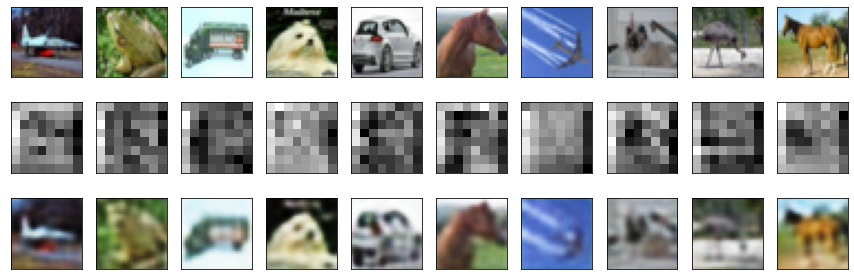

In [47]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 32, 32, 3))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(8,8))

## Save the model

In [48]:
convolutional_model.save('cifar10_autoencoder.h5')